In [1]:
import os
import pandas as pd
import janitor
import numpy as np

pd.set_option("display.max_columns", 100)

from utils.utils import fit_exp, save_mpl_fig
from utils.data_utils import pandas_to_tex
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(
    context="notebook", font_scale=1.05, style="whitegrid", palette="dark"
)  #  Darkgrid Whitegrid Dark White Ticksimport matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.lines as mlines
from scipy import stats

DATAPATH = "../data/individual_browsing_data.csv"
FIGSAVEDIR = "../figs"

df_ind = pd.read_csv(DATAPATH)
df_ind

,caseid,birthyr,gender,race,educ,pid3,pid7,presvote20post,inputstate,region,party,visits_adult,visits_nonadult,visits,prop_adult_visits,rep,duration_adult,duration_nonadult,duration,prop_adult_duration,yes_visit_adults,race2,cohort,age,age2,educ2
0,200661421,1963,2,1,4,3,3,1,39,2,D,0.0,1728.0,1728.0,0.000000,0.0,0.0,77642.0,77642.0,0.000000,0.0,1,1960,60,3600,4
1,200686597,1992,2,6,5,5,8,-1,48,3,NaN,243.0,3994.0,4237.0,5.735190,NaN,25952.0,234196.0,260148.0,9.975860,1.0,5,1990,31,961,4
2,200953869,1959,2,1,5,2,7,2,42,1,R,0.0,20.0,20.0,0.000000,1.0,0.0,1182.0,1182.0,0.000000,0.0,1,1960,64,4096,4
3,201302005,1966,2,2,3,5,8,1,12,3,NaN,20.0,527.0,547.0,3.656307,NaN,6166.0,23855.0,30021.0,20.538956,1.0,2,1970,57,3249,3
4,201590505,1977,1,4,5,3,3,1,6,4,D,0.0,11086.0,11086.0,0.000000,0.0,0.0,383161.0,383161.0,0.000000,0.0,4,1980,46,2116,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1802885,1935,1,1,6,4,5,2,12,3,R,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1,1940,88,7744,4
1196,1809723,1943,1,1,2,1,1,1,51,3,D,0.0,9805.0,9805.0,0.000000,0.0,0.0,1272613.0,1272613.0,0.000000,0.0,1,1940,80,6400,2
1197,1827351,1947,1,1,5,3,4,1,31,2,I,0.0,543.0,543.0,0.000000,NaN,0.0,23929.0,23929.0,0.000000,0.0,1,1950,76,5776,4
1198,1924249,1980,1,7,4,2,7,2,6,4,R,182.0,21379.0,21561.0,0.844117,1.0,2094.0,309876.0,311970.0,0.671218,1.0,5,1980,43,1849,4


### Distribution of visits to adult sites

In [2]:
outcome_var = "visits_adult"

In [3]:
# (fold cell) Prep data
qcut_opts = {
    "q": 10,
    "precision": 1,
    "labels": range(10, 101, 10),
    "duplicates": "drop",
}

_df = df_ind.query(f"{outcome_var}>0").assign(
    **{f"decile_{outcome_var}": lambda df: pd.qcut(df[outcome_var], **qcut_opts)}
)
print(f"N = {len(_df)}")
_df.head(3)

N = 361


,caseid,birthyr,gender,race,educ,pid3,pid7,presvote20post,inputstate,region,party,visits_adult,visits_nonadult,visits,prop_adult_visits,rep,duration_adult,duration_nonadult,duration,prop_adult_duration,yes_visit_adults,race2,cohort,age,age2,educ2,decile_visits_adult
1,200686597,1992,2,6,5,5,8,-1,48,3,NaN,243.0,3994.0,4237.0,5.735190,NaN,25952.0,234196.0,260148.0,9.975860,1.0,5,1990,31,961,4,80
3,201302005,1966,2,2,3,5,8,1,12,3,NaN,20.0,527.0,547.0,3.656307,NaN,6166.0,23855.0,30021.0,20.538956,1.0,2,1970,57,3249,3,40
5,201631749,1996,1,3,5,3,4,1,6,4,I,1107.0,16361.0,17468.0,6.337302,NaN,31506.0,411490.0,442996.0,7.112028,1.0,3,2000,27,729,4,100


/tmp/ipykernel_27469/205201283.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(


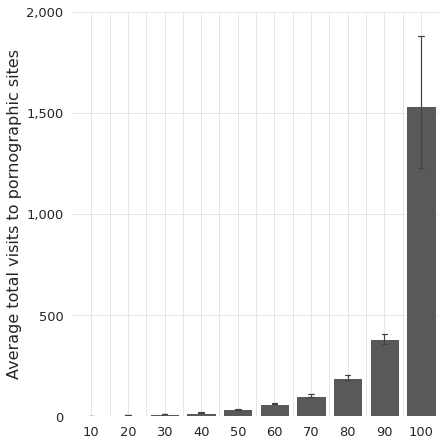

In [4]:
# (fold cell) Plot deciles
scale = 0.7
fig, ax = plt.subplots(figsize=(9 * scale, 9 * scale))

sns.barplot(
    x=f"decile_{outcome_var}",
    y=outcome_var,
    data=_df,
    color=".35",
    ci=95,
    errwidth=1.2,
    capsize=0.15,
)
ax.set_yticks(range(0, 2500, 500))
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ","))
)
ax.set_xlabel("")
ax.set_ylabel("Average total visits to pornographic sites", size=16)
ax.tick_params(axis="both", which="major", labelsize=13)
plt.tight_layout()
ax.xaxis.grid(True)
ax.get_xaxis().set_minor_locator(ticker.AutoMinorLocator(2))
ax.xaxis.grid(True, which="both", color=".9")
ax.yaxis.grid(True, which="both", color=".9")

sns.despine(left=True, bottom=True)
save_mpl_fig(os.path.join(FIGSAVEDIR, "distribution_visits_to_adultsites"))

In [5]:
# Get table of percentiles (fold cell)
ntiles = [
    0.0,
    0.1,
    0.2,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.8,
    0.9,
    0.95,
#     0.96,
#     0.97,
#     0.98,
#     0.99,
#     1,
]
tab_deciles = (
    _df[outcome_var]
    .quantile(ntiles)
    .reset_index()
    .rename_column("index", "Percentile")
    .assign(**{outcome_var: lambda df: df[outcome_var].apply(int)})
)
pandas_to_tex(tab_deciles, "../tabs/percentiles_visits_adultsites_by_individuals")
tab_deciles

/mnt/d/adult/scripts/utils/data_utils.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tex_table = df.to_latex(index=index, header=False)


,Percentile,visits_adult
0,0.00,1
1,0.10,4
2,0.20,7
3,0.30,12
4,0.40,25
5,0.50,46
6,0.60,77
7,0.70,134
8,0.80,262
9,0.90,524


### Distribution of visits to adult sites, by partisanship

In [6]:
# (fold cell) Get deciles mean and CI (from SEM)
df_decile_agg = (
    df_ind
    # Make deciles by party
    .query(f"{outcome_var}>0")
    .assign(
        **{
            f"decile_{outcome_var}": lambda df: (
                df.groupby("party")[outcome_var].transform(
                    lambda x: pd.qcut(x, **qcut_opts)
                )
            )
        },
    )
    .groupby(["party", f"decile_{outcome_var}"])[outcome_var]
    .agg(["mean", "sem"])
    .reset_index()
    # Get CI from SEM
    .assign(
        ll=lambda df: df["mean"] - 1.96 * df["sem"],
        hl=lambda df: df["mean"] + 1.96 * df["sem"],
        ci=lambda df: df["hl"] - df["ll"],
    )
    #     Manually "dodge" the points to plot, by party
    .assign(
        **{f"decile_{outcome_var}": lambda df: df[f"decile_{outcome_var}"].astype(int)}
    )
    .assign(
        **{
            f"decile_{outcome_var}": lambda df: np.where(
                df.party == "D",
                df[f"decile_{outcome_var}"] - 4,
                df[f"decile_{outcome_var}"],
            )
        }
    )
    .assign(
        **{
            f"decile_{outcome_var}": lambda df: np.where(
                df.party == "R",
                df[f"decile_{outcome_var}"] - 6,
                df[f"decile_{outcome_var}"],
            )
        }
    )
)
df_decile_agg.head(4)

,party,decile_visits_adult,mean,sem,ll,hl,ci
0,D,6,2.000000,0.129099,1.746965,2.253035,0.506070
1,D,16,5.083333,0.179741,4.731041,5.435625,0.704584
2,D,26,8.000000,0.327327,7.358439,8.641561,1.283121
3,D,36,11.533333,0.412503,10.724827,12.341839,1.617012


In [7]:
# Prep data for scatter
df_visits = (
    df_ind.dropna(subset="party").query(f"{outcome_var}>0")
    # Retrieve quantiles of visits to adult sites
    .case_when(
        # when R, D, or I
        lambda df: df.party == "R",
        lambda df: df[outcome_var].apply(
            lambda x: stats.percentileofscore(
                df.query("party=='R'")[outcome_var].sort_values(), x
            )
        ),
        lambda df: df.party == "D",
        lambda df: df[outcome_var].apply(
            lambda x: stats.percentileofscore(
                df.query("party=='D'")[outcome_var].sort_values(), x
            )
        ),
        lambda df: df.party == "I",
        lambda df: df[outcome_var].apply(
            lambda x: stats.percentileofscore(
                df.query("party=='I'")[outcome_var].sort_values(), x
            )
        ),
        # else nan
        np.nan,
        column_name=f"quantiles_{outcome_var}",
    )
)
df_visits.head(3)

/home/lsys/miniconda3/lib/python3.10/site-packages/pandas_flavor/register.py:153: DeprecationWarning: The last argument in the variable arguments has been assigned as the default. Note however that this will be deprecated in a future release; use an even number of boolean conditions and values, and pass the default argument to the `default` parameter instead.
  return method(self._obj, *args, **kwargs)


,caseid,birthyr,gender,race,educ,pid3,pid7,presvote20post,inputstate,region,party,visits_adult,visits_nonadult,visits,prop_adult_visits,rep,duration_adult,duration_nonadult,duration,prop_adult_duration,yes_visit_adults,race2,cohort,age,age2,educ2,quantiles_visits_adult
5,201631749,1996,1,3,5,3,4,1,6,4,I,1107.0,16361.0,17468.0,6.337302,NaN,31506.0,411490.0,442996.0,7.112028,1.0,3,2000,27,729,4,91.176471
19,203457165,1960,2,1,3,1,1,1,41,4,D,21.0,28364.0,28385.0,0.073983,0.0,316.0,689501.0,689817.0,0.045809,1.0,1,1960,63,3969,3,46.202532
20,204288513,1991,1,1,2,3,4,2,54,3,I,36.0,79886.0,79922.0,0.045044,NaN,320.0,790119.0,790439.0,0.040484,1.0,1,1990,32,1024,2,41.176471


In [8]:
# (fold cell) Standard Options
palette = {"R": "Maroon", "D": "Navy"}
errorlinestyle = {"R": "-.", "D": "-"}

running_var = f"quantiles_{outcome_var}"

scatter_opts = {
    "x": running_var,
    "y": outcome_var,
    "marker": "x",
    "s": 15,
    "linewidths": 0.5,
    "alpha": 0.4,
}

errorbar_opts = {
    "x": f"decile_{outcome_var}",
    "y": "mean",
    "yerr": "ci",
    "elinewidth": 2.5,
    "ls": "none",
    "alpha": 0.6,
    "zorder": 1,
}
scatter_decile_opts = {
    "x": f"decile_{outcome_var}",
    "y": "mean",
    "marker": "o",
    "s": 60,
    "alpha": 0.85,
}
line_opts = {
    "lw": 1.5,
    "alpha": 0.5,
}

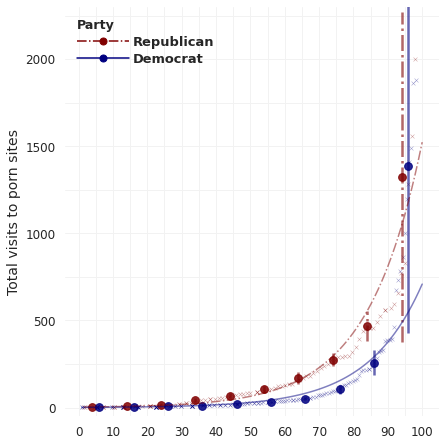

In [9]:
# (fold cell) Plot splits by party
scale = 0.7
fig, ax = plt.subplots(figsize=(9 * scale, 9 * scale))

# Scatterpoints for individuals
for party in ["R", "D"]:
    plt.scatter(
        data=df_visits.query(f"party=='{party}'"), color=palette[party], **scatter_opts
    )
# Error bars
for party in ["R", "D"]:
    eb = plt.errorbar(
        data=df_decile_agg.query(f"party=='{party}'"),
        color=palette[party],
        **errorbar_opts,
    )
    if party == "R":
        eb[-1][0].set_linestyle(errorlinestyle["R"])

# Scatter for the 2 parties x 10 deciles
for party in ["R", "D"]:
    plt.scatter(
        data=df_decile_agg.query(f"party=='{party}'"),
        color=palette[party],
        **scatter_decile_opts,
    )

# Connect deciles
for party in ["R", "D"]:
    y = df_visits.query(f"party=='{party}'")[outcome_var]
    x = df_visits.query(f"party=='{party}'")[running_var]
    x_fitted, y_fitted = fit_exp(x, y)
    plt.plot(
        x_fitted,
        y_fitted,
        color=palette[party],
        linestyle=errorlinestyle[party],
        **line_opts,
    )

# Figure settings
ax.set_xticks(range(0, 110, 10))
ax.set_xlabel("")
ax.set_ylabel("Total visits to porn sites", size=14)
ax.tick_params(axis="both", which="major", labelsize=12)
# ax.set_yticks(range(0,50,10))
ax.set_ylim(-50, 2300)

# Grids
ax.xaxis.grid(True)
ax.get_xaxis().set_minor_locator(ticker.AutoMinorLocator(2))
ax.get_yaxis().set_minor_locator(ticker.AutoMinorLocator(2))
ax.xaxis.grid(True, which="both", color=".95")
ax.yaxis.grid(True, which="both", color=".95")

# Custom Legend
rep_hand = mlines.Line2D(
    [], [], color="maroon", marker="o", ls="-.", markersize=7, label="Republican"
)
dem_hand = mlines.Line2D(
    [],
    [],
    color="navy",
    marker="o",
    ls="-",
    markersize=7,
    label="Democrat",
)
custom_legend = plt.legend(
    handles=[rep_hand, dem_hand],
    handlelength=4,
    handletextpad=0.3,
    labelspacing=0.3,
    title="Party",
    frameon=False,
    prop={"weight": "bold", "size": 13},
    #     title_fontproperties={'weight':'bold', 'size':14},
)
custom_legend._legend_box.align = "left"
custom_legend.get_title().set_weight("bold")

sns.despine(left=True, bottom=True)
plt.tight_layout()
save_mpl_fig(os.path.join(FIGSAVEDIR, "distribution_visits_to_adultsites_by_party"))

In [10]:
# (fold cell) Get table of percentiles
ntiles = [
    0.0,
    0.1,
    0.2,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.8,
    0.9,
    0.95,
#     0.96,
#     0.97,
#     0.98,
#     0.99,
#     1,
]
_tab_R = (
    _df.query("party=='R'")[outcome_var]
    .quantile(ntiles)
    .reset_index()
    .rename_column("index", "Percentile")
    .rename_column(f"{outcome_var}", f"{outcome_var}_R")
)
_tab_D = (
    _df.query("party=='D'")[outcome_var]
    .quantile(ntiles)
    .reset_index()
    .rename_column("index", "Percentile")
    .rename_column(f"{outcome_var}", f"{outcome_var}_D")
)

tab_perc = _tab_R.merge(_tab_D, on="Percentile", how="left", validate="1:1").assign(
    **{f"{outcome_var}_R": lambda df: df[f"{outcome_var}_R"].map("{:,.0f}".format)},
    **{f"{outcome_var}_D": lambda df: df[f"{outcome_var}_D"].map("{:,.0f}".format)},
)
pandas_to_tex(tab_perc, "../tabs/percentiles_visits_adultsites_by_individuals_by_party")
tab_perc

/mnt/d/adult/scripts/utils/data_utils.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tex_table = df.to_latex(index=index, header=False)


,Percentile,visits_adult_R,visits_adult_D
0,0.00,1,1
1,0.10,5,4
2,0.20,10,6
3,0.30,27,9
4,0.40,53,15
5,0.50,85,26
6,0.60,129,40
7,0.70,227,74
8,0.80,335,157
9,0.90,564,386


### Distribution of proportion of visits to adult sites

In [11]:
outcome_var = "prop_adult_visits"

In [12]:
# (fold cell) Prep data
qcut_opts = {
    "q": 10,
    "precision": 1,
    "labels": range(10, 101, 10),
    "duplicates": "drop",
}

_df = df_ind.query(f"{outcome_var}>0").assign(
    **{f"decile_{outcome_var}": lambda df: pd.qcut(df[outcome_var], **qcut_opts)}
)
print(f"N = {len(_df)}")
_df.head(3)

N = 361


,caseid,birthyr,gender,race,educ,pid3,pid7,presvote20post,inputstate,region,party,visits_adult,visits_nonadult,visits,prop_adult_visits,rep,duration_adult,duration_nonadult,duration,prop_adult_duration,yes_visit_adults,race2,cohort,age,age2,educ2,decile_prop_adult_visits
1,200686597,1992,2,6,5,5,8,-1,48,3,NaN,243.0,3994.0,4237.0,5.735190,NaN,25952.0,234196.0,260148.0,9.975860,1.0,5,1990,31,961,4,70
3,201302005,1966,2,2,3,5,8,1,12,3,NaN,20.0,527.0,547.0,3.656307,NaN,6166.0,23855.0,30021.0,20.538956,1.0,2,1970,57,3249,3,60
5,201631749,1996,1,3,5,3,4,1,6,4,I,1107.0,16361.0,17468.0,6.337302,NaN,31506.0,411490.0,442996.0,7.112028,1.0,3,2000,27,729,4,70


/tmp/ipykernel_27469/4290297481.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(


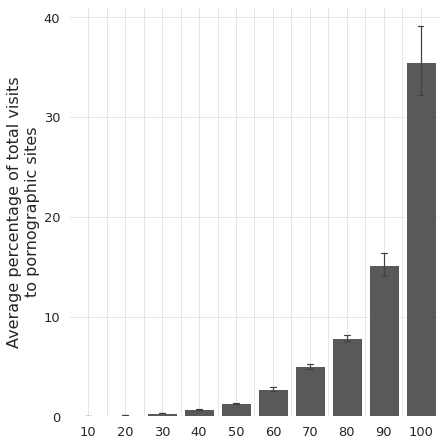

In [13]:
# (fold cell) Plot deciles
scale = 0.7
fig, ax = plt.subplots(figsize=(9 * scale, 9 * scale))

sns.barplot(
    x=f"decile_{outcome_var}",
    y=outcome_var,
    data=_df,
    color=".35",
    ci=95,
    errwidth=1.2,
    capsize=0.15,
)
ax.set_yticks(range(0, 41, 10))
ax.set_xlabel("")
ax.set_ylabel("Average percentage of total visits\nto pornographic sites", size=16)
ax.tick_params(axis="both", which="major", labelsize=13)
plt.tight_layout()
ax.xaxis.grid(True)
ax.get_xaxis().set_minor_locator(ticker.AutoMinorLocator(2))
ax.xaxis.grid(True, which="both", color=".9")
ax.yaxis.grid(True, which="both", color=".9")

sns.despine(left=True, bottom=True)
save_mpl_fig(os.path.join(FIGSAVEDIR, "distribution_proportion_visits_to_adultsites"))

In [14]:
# Get table of percentiles (fold cell)
ntiles = [
    0.0,
    0.1,
    0.2,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.8,
    0.9,
    0.95,
#     0.96,
#     0.97,
#     0.98,
#     0.99,
#     1,
]
tab_deciles = (
    _df[outcome_var]
    .quantile(ntiles)
    .reset_index()
    .rename_column("index", "Percentile")
    .assign(**{outcome_var: lambda df: df[outcome_var].round(1)})
)
pandas_to_tex(
    tab_deciles, "../tabs/percentiles_proportion_visits_adultsites_by_individuals"
)
tab_deciles

/mnt/d/adult/scripts/utils/data_utils.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tex_table = df.to_latex(index=index, header=False)


,Percentile,prop_adult_visits
0,0.00,0.0
1,0.10,0.1
2,0.20,0.2
3,0.30,0.5
4,0.40,1.0
5,0.50,1.6
6,0.60,3.7
7,0.70,6.3
8,0.80,9.7
9,0.90,22.0


### Distribution of proportion of visits to adult sites, by partisanship

In [15]:
# (fold cell) Get deciles mean and CI (from SEM)
df_decile_agg = (
    df_ind
    # Make deciles by party
    .query(f"{outcome_var}>0")
    .assign(
        **{
            f"decile_{outcome_var}": lambda df: (
                df.groupby("party")[outcome_var].transform(
                    lambda x: pd.qcut(x, **qcut_opts)
                )
            )
        },
    )
    .groupby(["party", f"decile_{outcome_var}"])[outcome_var]
    .agg(["mean", "sem"])
    .reset_index()
    # Get CI from SEM
    .assign(
        ll=lambda df: df["mean"] - 1.96 * df["sem"],
        hl=lambda df: df["mean"] + 1.96 * df["sem"],
        ci=lambda df: df["hl"] - df["ll"],
    )
    # Manually "dodge" the points to plot, by party
    .assign(
        **{f"decile_{outcome_var}": lambda df: df[f"decile_{outcome_var}"].astype(int)}
    )
    .assign(
        **{
            f"decile_{outcome_var}": lambda df: np.where(
                df.party == "D",
                df[f"decile_{outcome_var}"] - 4,
                df[f"decile_{outcome_var}"],
            )
        }
    )
    .assign(
        **{
            f"decile_{outcome_var}": lambda df: np.where(
                df.party == "R",
                df[f"decile_{outcome_var}"] - 6,
                df[f"decile_{outcome_var}"],
            )
        }
    )
)
df_decile_agg.head(4)

,party,decile_prop_adult_visits,mean,sem,ll,hl,ci
0,D,6,0.032678,0.003670,0.025485,0.039871,0.014386
1,D,16,0.090623,0.005544,0.079758,0.101488,0.021731
2,D,26,0.204373,0.011916,0.181017,0.227729,0.046712
3,D,36,0.368017,0.013563,0.341434,0.394599,0.053166


In [16]:
# Prep data for scatter
df_visits = (
    df_ind.dropna(subset="party").query(f"{outcome_var}>0")
    # Retrieve quantiles of visits to adult sites
    .case_when(
        # when R, D, or I
        lambda df: df.party == "R",
        lambda df: df[outcome_var].apply(
            lambda x: stats.percentileofscore(
                df.query("party=='R'")[outcome_var].sort_values(), x
            )
        ),
        lambda df: df.party == "D",
        lambda df: df[outcome_var].apply(
            lambda x: stats.percentileofscore(
                df.query("party=='D'")[outcome_var].sort_values(), x
            )
        ),
        lambda df: df.party == "I",
        lambda df: df[outcome_var].apply(
            lambda x: stats.percentileofscore(
                df.query("party=='I'")[outcome_var].sort_values(), x
            )
        ),
        # else nan
        np.nan,
        column_name=f"quantiles_{outcome_var}",
    )
)
df_visits.head(3)

/home/lsys/miniconda3/lib/python3.10/site-packages/pandas_flavor/register.py:153: DeprecationWarning: The last argument in the variable arguments has been assigned as the default. Note however that this will be deprecated in a future release; use an even number of boolean conditions and values, and pass the default argument to the `default` parameter instead.
  return method(self._obj, *args, **kwargs)


,caseid,birthyr,gender,race,educ,pid3,pid7,presvote20post,inputstate,region,party,visits_adult,visits_nonadult,visits,prop_adult_visits,rep,duration_adult,duration_nonadult,duration,prop_adult_duration,yes_visit_adults,race2,cohort,age,age2,educ2,quantiles_prop_adult_visits
5,201631749,1996,1,3,5,3,4,1,6,4,I,1107.0,16361.0,17468.0,6.337302,NaN,31506.0,411490.0,442996.0,7.112028,1.0,3,2000,27,729,4,64.705882
19,203457165,1960,2,1,3,1,1,1,41,4,D,21.0,28364.0,28385.0,0.073983,0.0,316.0,689501.0,689817.0,0.045809,1.0,1,1960,63,3969,3,13.291139
20,204288513,1991,1,1,2,3,4,2,54,3,I,36.0,79886.0,79922.0,0.045044,NaN,320.0,790119.0,790439.0,0.040484,1.0,1,1990,32,1024,2,5.882353


In [17]:
# (fold cell) Standard Options
palette = {"R": "Maroon", "D": "Navy"}
errorlinestyle = {"R": "-.", "D": "-"}

running_var = f"quantiles_{outcome_var}"

scatter_opts = {
    "x": running_var,
    "y": outcome_var,
    "marker": "x",
    "s": 15,
    "linewidths": 0.5,
    "alpha": 0.4,
}

errorbar_opts = {
    "x": f"decile_{outcome_var}",
    "y": "mean",
    "yerr": "ci",
    "elinewidth": 2.5,
    "ls": "none",
    "alpha": 0.6,
    "zorder": 1,
}
scatter_decile_opts = {
    "x": f"decile_{outcome_var}",
    "y": "mean",
    "marker": "o",
    "s": 60,
    "alpha": 0.85,
}
line_opts = {
    "lw": 1.5,
    "alpha": 0.5,
}

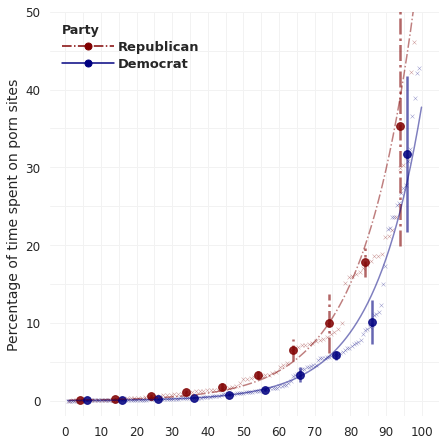

In [18]:
# (fold cell) Plot splits by party
scale = 0.7
fig, ax = plt.subplots(figsize=(9 * scale, 9 * scale))

# Scatterpoints for individuals
for party in ["R", "D"]:
    plt.scatter(
        data=df_visits.query(f"party=='{party}'"), color=palette[party], **scatter_opts
    )
# Error bars
for party in ["R", "D"]:
    eb = plt.errorbar(
        data=df_decile_agg.query(f"party=='{party}'"),
        color=palette[party],
        **errorbar_opts,
    )
    if party == "R":
        eb[-1][0].set_linestyle(errorlinestyle["R"])

# Scatter for the 2 parties x 10 deciles
for party in ["R", "D"]:
    plt.scatter(
        data=df_decile_agg.query(f"party=='{party}'"),
        color=palette[party],
        **scatter_decile_opts,
    )

# Connect deciles
for party in ["R", "D"]:
    y = df_visits.query(f"party=='{party}'")[outcome_var]
    x = df_visits.query(f"party=='{party}'")[running_var]
    x_fitted, y_fitted = fit_exp(x, y)
    plt.plot(
        x_fitted,
        y_fitted,
        color=palette[party],
        linestyle=errorlinestyle[party],
        **line_opts,
    )

# Figure settings
ax.set_xticks(range(0, 110, 10))
ax.set_xlabel("")
ax.set_ylabel("Percentage of time spent on porn sites", size=14)
ax.tick_params(axis="both", which="major", labelsize=12)
ax.set_yticks(range(0, 60, 10))
ax.set_ylim(-2, 50)

# Grids
ax.xaxis.grid(True)
ax.get_xaxis().set_minor_locator(ticker.AutoMinorLocator(2))
ax.get_yaxis().set_minor_locator(ticker.AutoMinorLocator(2))
ax.xaxis.grid(True, which="both", color=".95")
ax.yaxis.grid(True, which="both", color=".95")

# Custom Legend
rep_hand = mlines.Line2D(
    [], [], color="maroon", marker="o", ls="-.", markersize=7, label="Republican"
)
dem_hand = mlines.Line2D(
    [],
    [],
    color="navy",
    marker="o",
    ls="-",
    markersize=7,
    label="Democrat",
)
custom_legend = plt.legend(
    handles=[rep_hand, dem_hand],
    handlelength=4,
    handletextpad=0.3,
    labelspacing=0.3,
    title="Party",
    frameon=False,
    prop={"weight": "bold", "size": 13},
    #     title_fontproperties={'weight':'bold', 'size':14},
)
custom_legend._legend_box.align = "left"
custom_legend.get_title().set_weight("bold")

sns.despine(left=True, bottom=True)
plt.tight_layout()
save_mpl_fig(
    os.path.join(FIGSAVEDIR, "distribution_proportion_visits_to_adultsites_by_party")
)

In [19]:
# (fold cell) Get table of percentiles
ntiles = [
    0.0,
    0.1,
    0.2,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.8,
    0.9,
    0.95,
#     0.96,
#     0.97,
#     0.98,
#     0.99,
#     1,
]
_tab_R = (
    _df.query("party=='R'")[outcome_var]
    .quantile(ntiles)
    .reset_index()
    .rename_column("index", "Percentile")
    .rename_column(f"{outcome_var}", f"{outcome_var}_R")
)
_tab_D = (
    _df.query("party=='D'")[outcome_var]
    .quantile(ntiles)
    .reset_index()
    .rename_column("index", "Percentile")
    .rename_column(f"{outcome_var}", f"{outcome_var}_D")
)

tab_perc = _tab_R.merge(_tab_D, on="Percentile", how="left", validate="1:1").assign(
    **{f"{outcome_var}_R": lambda df: df[f"{outcome_var}_R"].map("{:,.1f}".format)},
    **{f"{outcome_var}_D": lambda df: df[f"{outcome_var}_D"].map("{:,.1f}".format)},
)
pandas_to_tex(
    tab_perc, "../tabs/percentiles_proportion_visits_adultsites_by_individuals_by_party"
)
tab_perc

/mnt/d/adult/scripts/utils/data_utils.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tex_table = df.to_latex(index=index, header=False)


,Percentile,prop_adult_visits_R,prop_adult_visits_D
0,0.00,0.0,0.0
1,0.10,0.1,0.1
2,0.20,0.4,0.1
3,0.30,0.8,0.3
4,0.40,1.4,0.5
5,0.50,2.8,1.0
6,0.60,4.3,1.9
7,0.70,7.7,4.6
8,0.80,16.0,7.0
9,0.90,21.1,18.8
